In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
# 加载 Excel 文件并解析 Sheet1
file_path = 'data_input_auto/Brent-WTI价差.xlsx'
excel_data = pd.ExcelFile(file_path)
sheet = excel_data.parse('Sheet1')

# 重命名列并确保日期格式正确
sheet.rename(columns={'DataTime': 'Date'}, inplace=True)
sheet['Date'] = pd.to_datetime(sheet['Date'], errors='coerce')

# 创建完整的日期范围，并重设索引以确保日期范围内的数据完整
last_day = pd.to_datetime(sheet.loc[sheet['Brent - Wti 价差(wind)'].last_valid_index(), 'Date'])
full_date_range = pd.date_range(start=sheet['Date'].min(), end=last_day + pd.Timedelta(days=20), freq='B')
sheet = sheet.set_index('Date').reindex(full_date_range).rename_axis('Date').reset_index()
sheet


,Date,Brent - Wti 价差(wind),Brent原油期货连1合约价格/路透,GPR地缘风险指数/7DMA,北海现货成交量/platts/5undefinedMA,Aframax油轮运费（休斯顿-鹿特丹）（美元/桶）,欧洲CDU装置检修量,美债10-2年国债收益率利差,美国PADD3原油库存(预测/季节性/供应价差拟合)超季节性/3年,欧洲柴油单一利润
0,1985-01-01,NaN,NaN,230.0400,NaN,NaN,NaN,NaN,NaN,NaN
1,1985-01-02,NaN,NaN,172.8600,NaN,NaN,NaN,NaN,NaN,NaN
2,1985-01-03,NaN,NaN,147.7167,NaN,NaN,NaN,NaN,NaN,NaN
3,1985-01-04,NaN,NaN,150.1300,NaN,NaN,NaN,NaN,NaN,NaN
4,1985-01-07,NaN,NaN,136.3557,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
10658,2025-11-07,NaN,NaN,NaN,NaN,NaN,176.0,NaN,-1992.0664,NaN
10659,2025-11-10,NaN,NaN,NaN,NaN,NaN,176.0,NaN,NaN,NaN
10660,2025-11-11,NaN,NaN,NaN,NaN,NaN,176.0,NaN,NaN,NaN
10661,2025-11-12,NaN,NaN,NaN,NaN,NaN,176.0,NaN,NaN,NaN


In [5]:
sheet.columns

Index(['Date', 'Brent - Wti 价差(wind)', 'Brent原油期货连1合约价格/路透', 'GPR地缘风险指数/7DMA',
       '北海现货成交量/platts/5undefinedMA', 'Aframax油轮运费（休斯顿-鹿特丹）（美元/桶）',
       '欧洲CDU装置检修量', '美债10-2年国债收益率利差', '美国PADD3原油库存(预测/季节性/供应价差拟合)超季节性/3年',
       '欧洲柴油单一利润'],
      dtype='object')

In [6]:

sheet = sheet.rename(columns={'Brent - Wti 价差(wind)':'Brent-WTI价差'})
#############  处理缺失值 ##############
fill_methods = {
    'GPR地缘风险指数/7DMA': 'interpolate',    
    '北海现货成交量/platts/5undefinedMA': 'interpolate', 
    'Aframax油轮运费（休斯顿-鹿特丹）（美元/桶）': 'interpolate',
    '欧洲CDU装置检修量': 'interpolate', 
    '美债10-2年国债收益率利差': 'interpolate',
    '美国PADD3原油库存(预测/季节性/供应价差拟合)超季节性/3年':'interpolate',
    '欧洲柴油单一利润':'interpolate',
} 
sheet_daily = fill_missing_values(sheet, fill_methods, return_only_filled=False)

# 添加未来20天的数据
sheet_daily = pd.concat([sheet_daily, pd.DataFrame({'Date': pd.bdate_range(sheet_daily['Date'].max() + pd.Timedelta(days=1), periods=20)})], ignore_index=True)


sheet_daily['GPR地缘风险指数/7DMA_提前30天'] = sheet_daily['GPR地缘风险指数/7DMA'].shift(30)
sheet_daily['北海现货成交量/platts/5undefinedMA_提前30天'] = sheet_daily['北海现货成交量/platts/5undefinedMA'].shift(30)
sheet_daily['Aframax油轮运费（休斯顿-鹿特丹）（美元/桶）_提前30天'] = sheet_daily['Aframax油轮运费（休斯顿-鹿特丹）（美元/桶）'].shift(30)
sheet_daily['欧洲CDU装置检修量_提前30天'] = sheet_daily['欧洲CDU装置检修量'].shift(30)
sheet_daily['美债10-2年国债收益率利差_提前30天'] = sheet_daily['美债10-2年国债收益率利差'].shift(30)

sheet_daily['美债10-2年国债收益率利差_提前30天_逆序'] = reverse_column(sheet_daily, '美债10-2年国债收益率利差_提前30天')

last_day = sheet_daily['Date'].iloc[sheet_daily['Brent-WTI价差'].last_valid_index()]

sheet_daily = sheet_daily[sheet_daily['Date'] > '2023-06-01'] 

#############  删除预测指标最后一天之前 为空值的一整行  ##############
sheet_daily = sheet_daily[(sheet_daily['Date'] > last_day) | sheet_daily['Brent-WTI价差'].notna()]


In [7]:
# 重命名列
sheet_daily = sheet_daily.rename(columns={'Brent原油期货连1合约价格/路透': '布伦特原油期货价格'})
sheet_daily

,Date,Brent-WTI价差,布伦特原油期货价格,GPR地缘风险指数/7DMA,北海现货成交量/platts/5undefinedMA,Aframax油轮运费（休斯顿-鹿特丹）（美元/桶）,欧洲CDU装置检修量,美债10-2年国债收益率利差,美国PADD3原油库存(预测/季节性/供应价差拟合)超季节性/3年,欧洲柴油单一利润,GPR地缘风险指数/7DMA_提前30天,北海现货成交量/platts/5undefinedMA_提前30天,Aframax油轮运费（休斯顿-鹿特丹）（美元/桶）_提前30天,欧洲CDU装置检修量_提前30天,美债10-2年国债收益率利差_提前30天,美债10-2年国债收益率利差_提前30天_逆序
10023,2023-06-02,4.26,76.13,115.7171,NaN,4.2288,1185.0,-0.81,588.0667,15.88,103.0857,NaN,4.5151,1463.0,-0.60,2.43
10024,2023-06-05,4.80,76.71,129.5900,NaN,4.2603,1185.0,-0.77,1447.3467,16.85,112.4771,NaN,4.4288,1322.0,-0.60,2.43
10025,2023-06-06,4.84,76.29,132.7586,NaN,4.6671,1387.0,-0.81,2306.6267,16.43,122.9586,NaN,4.2466,1348.0,-0.46,2.29
10026,2023-06-07,4.49,76.95,121.7171,NaN,5.1452,1166.0,-0.77,3165.9067,16.77,115.4329,NaN,3.5096,1426.0,-0.47,2.30
10027,2023-06-08,5.01,75.96,106.9086,NaN,5.2007,1166.0,-0.79,4025.1867,16.89,118.6057,NaN,3.6068,1426.0,-0.54,2.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,2025-12-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.1571,760.0,6.0411,452.0,0.53,1.30
10679,2025-12-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.1571,760.0,6.0411,452.0,0.53,1.30
10680,2025-12-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.1571,760.0,6.0411,452.0,0.53,1.30
10681,2025-12-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.1571,760.0,6.0411,452.0,0.53,1.30


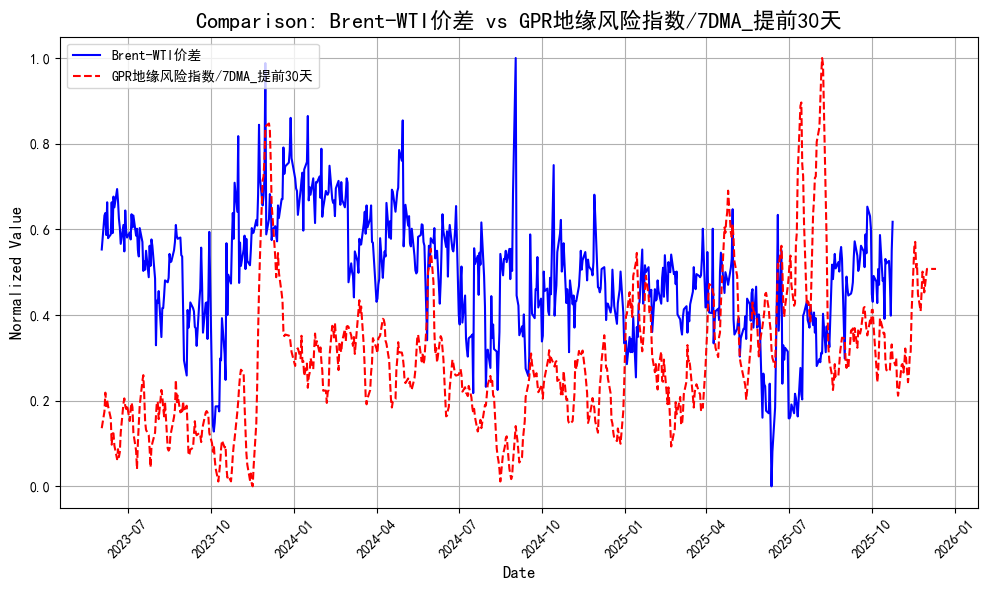

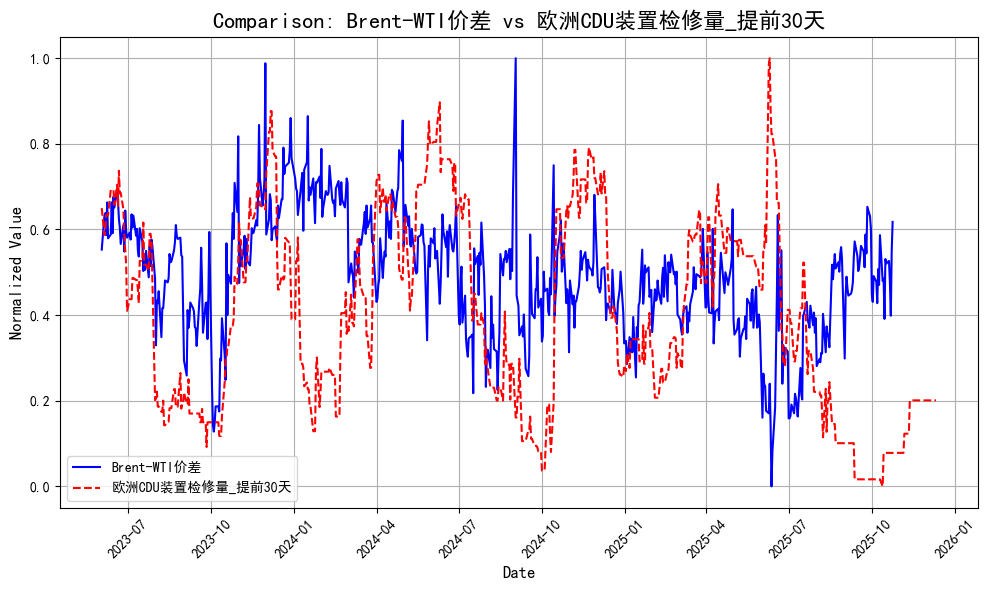

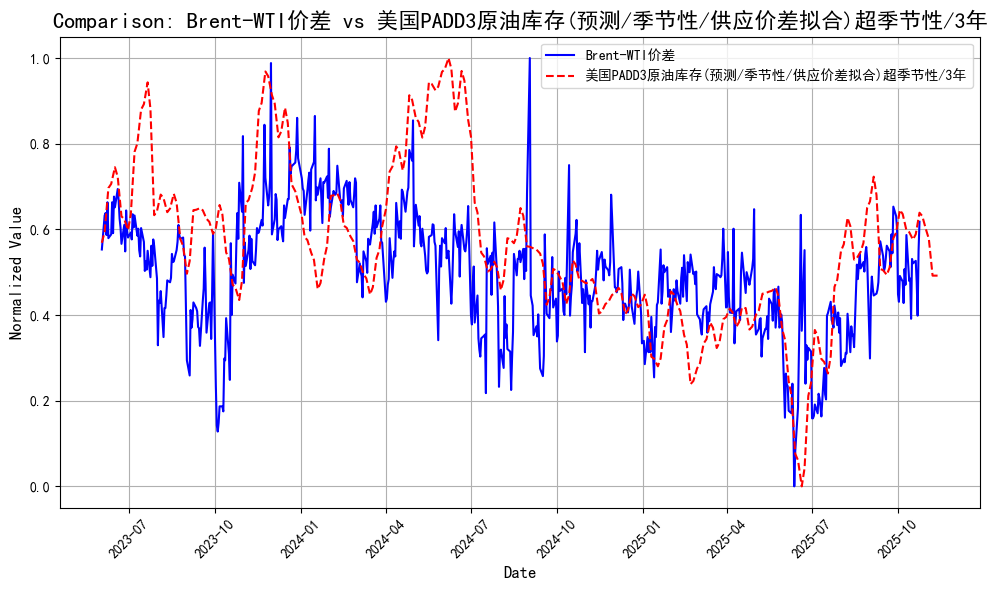

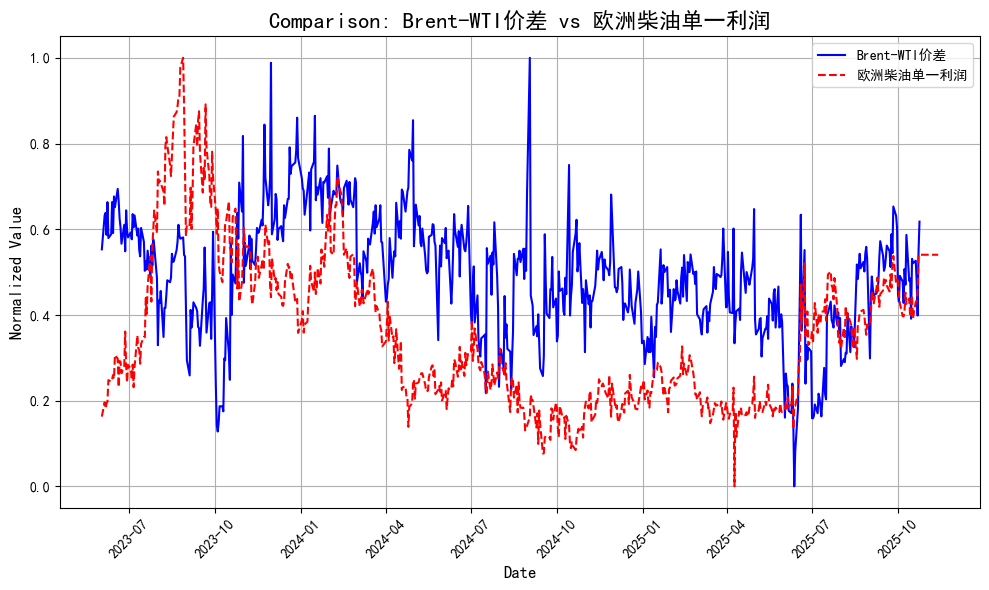

In [28]:
# 将Date列设置为索引
sheet_daily_plot = sheet_daily.set_index('Date')
# 选择2022年之前的数据
#sheet_daily_plot = sheet_daily_plot[:'2021-12-31']
# 选择2022年之后的数据
#sheet_daily_plot = sheet_daily_plot['2024-01-01':]

plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='Brent-WTI价差', 
    compare_cols=['GPR地缘风险指数/7DMA_提前30天',
#                  '北海现货成交量/platts/5undefinedMA_提前30天',
#                  'Aframax油轮运费（休斯顿-鹿特丹）（美元/桶）_提前30天',
                  '欧洲CDU装置检修量_提前30天',
#                  '美债10-2年国债收益率利差_提前30天_逆序',
                  '美国PADD3原油库存(预测/季节性/供应价差拟合)超季节性/3年',
                  '欧洲柴油单一利润'
                  ]
)

In [9]:
#############  划分训练集、测试集和未来数据 ##############
train_data = sheet_daily[sheet_daily['Date'] <= last_day]
test_period = 2
test_data = train_data[-test_period:]  
train_data = train_data[:-test_period]  
future_data = sheet_daily[sheet_daily['Date'] > last_day]

feature_columns = [
    'GPR地缘风险指数/7DMA_提前30天',
#    '北海现货成交量/platts/5undefinedMA_提前30天',
#    'Aframax油轮运费（休斯顿-鹿特丹）（美元/桶）_提前30天',
    '欧洲CDU装置检修量_提前30天',
#    '美债10-2年国债收益率利差_提前30天_逆序'
    '美国PADD3原油库存(预测/季节性/供应价差拟合)超季节性/3年',
    '欧洲柴油单一利润'
]

#############  准备训练、测试和未来数据的输入和输出 ##############
X_train = train_data[feature_columns]
y_train = train_data['Brent-WTI价差']

X_test = test_data[feature_columns]
y_test = test_data['Brent-WTI价差']

X_future = future_data[feature_columns]

In [10]:
# 初始化 MinMaxScaler
scaler = StandardScaler()

# 归一化特征数据
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

xgb = XGBRegressor(
    booster='gbtree',
    objective='reg:squarederror',
    n_estimators=int(1319.57),  
    learning_rate=0.0189,
    max_depth=int(2),  
    min_child_weight=3.437,
    subsample=0.65912,
    gamma=0.231618,
    reg_lambda=1.0457,
    reg_alpha= 0.1,
    random_state=42
)


xgb.fit(X_train_scaled, y_train)

# 训练集和测试集的预测
y_train_pred = xgb.predict(X_train_scaled)
y_test_pred = xgb.predict(X_test_scaled)

# 计算 MSE 和 R^2 分数
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MSE: {train_mse}, Train R^2: {train_r2}")
print(f"Test MSE: {test_mse}, Test R^2: {test_r2}")

# 未来预测
y_future_pred = xgb.predict(X_future_scaled)

test_data = test_data.copy()
future_data = future_data.copy()
test_data.loc[:, '预测值'] = y_test_pred
future_data.loc[:, '预测值_非全值'] = y_future_pred


# 未来预测 2 
X_all = np.vstack((X_train, X_test))
y_all = np.concatenate((y_train, y_test))
X_all_scaled = scaler.fit_transform(X_all)
model_all = xgb.fit(X_all_scaled,y_all)
y_future_pred_all = model_all.predict(X_future_scaled)
future_data.loc[:, '预测值'] = y_future_pred_all

Train MSE: 0.22658315417283312, Train R^2: 0.750805218441061
Test MSE: 0.06349721832975212, Test R^2: -0.20032548827508756


In [11]:
# 可视化
def adjust_future_predictions(y_test, future_data):
    gap = y_test.iloc[-1] - future_data['预测值'].iloc[0]
    #gap = -1
    future_data['预测值_全量'] = future_data['预测值'] + gap  
    return future_data

future_data = adjust_future_predictions(y_test, future_data)
future_data['预测值'] = future_data['预测值_全量']
future_data = future_data.drop('预测值_全量', axis=1)



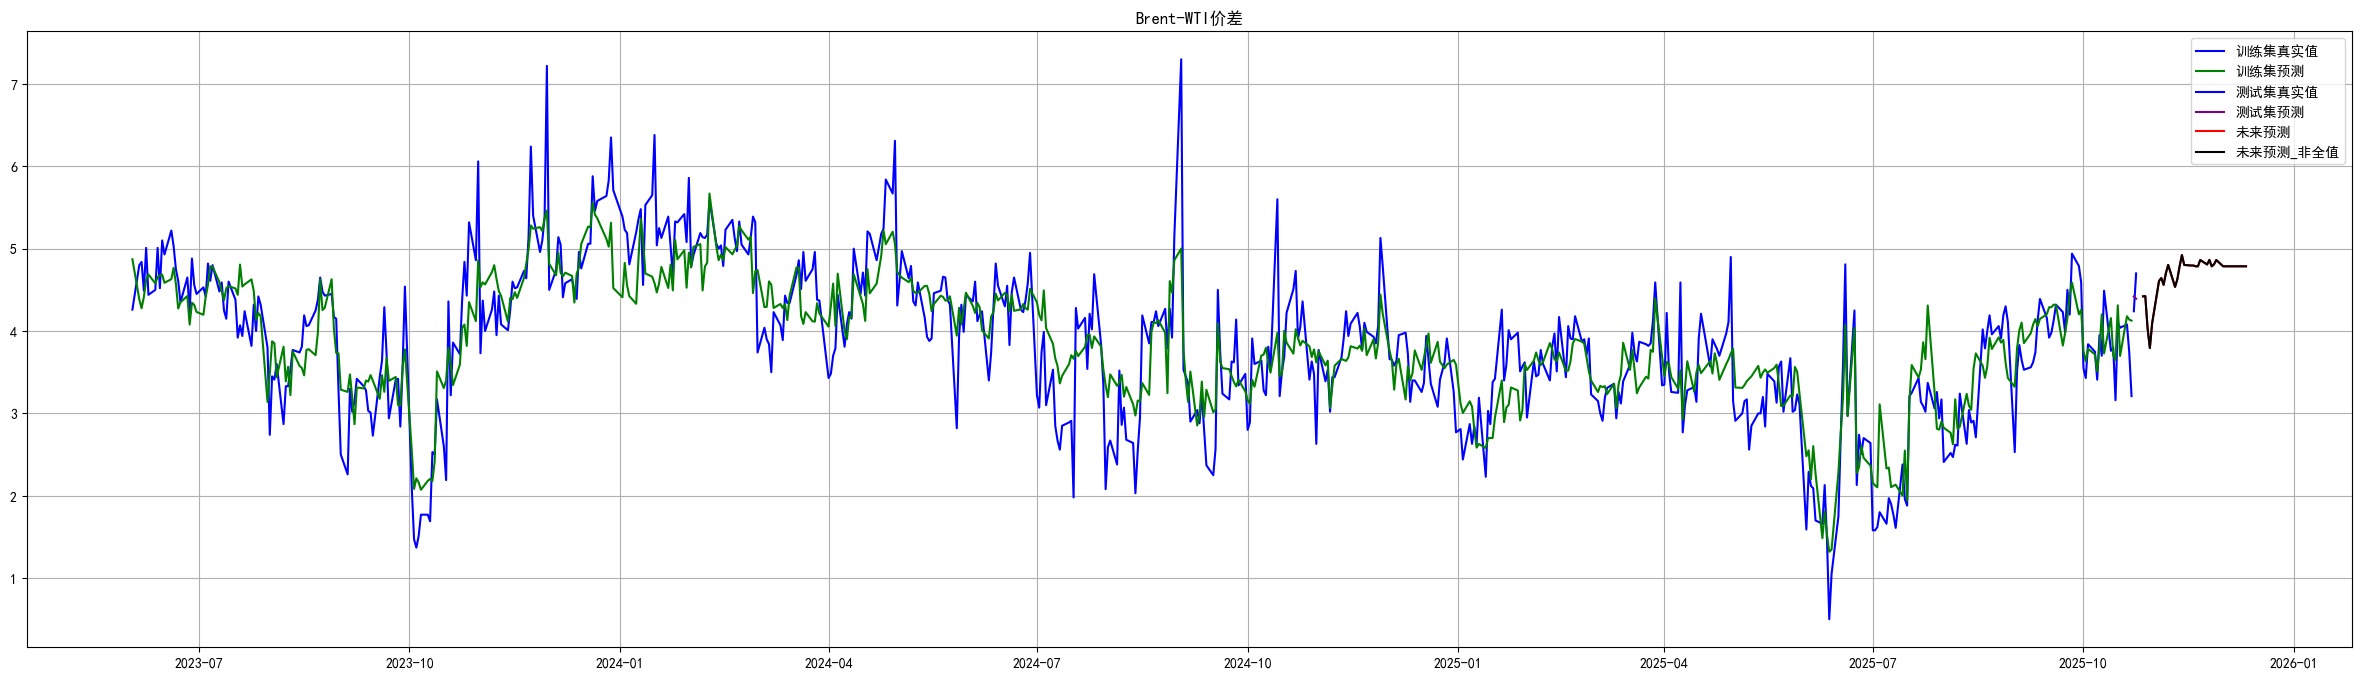

In [12]:
plt.figure(figsize=(30, 8))
plt.plot(train_data['Date'], y_train, label='训练集真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred, label='训练集预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集真实值', color='blue')
plt.plot(test_data['Date'], y_test_pred, label='测试集预测', color='purple')
plt.plot(future_data['Date'], y_future_pred, label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_非全值'], label='未来预测_非全值', color='black')

#plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
#plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')
plt.title('Brent-WTI价差')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# 读取WTI原油期货价格预测数据
wti_pre = pd.read_excel('data_output_auto/WTI原油期货价格预测2.xlsx')

wti_pre['Date'] = pd.to_datetime(wti_pre['Date'])
future_data['Date'] = pd.to_datetime(future_data['Date'])

# 合并WTI预测和价差预测数据
merged_df_brent = pd.merge(wti_pre, future_data[['Date', '预测值']], on='Date', how='inner')

# 计算brent预测值 (WTI + 价差)
merged_df_brent['Brent原油期货价格预测'] = merged_df_brent['WTI原油期货价格预测'] + merged_df_brent['预测值']

# 显示结果
merged_df_brent.tail()

,Date,WTI原油期货价格预测,预测值,Brent原油期货价格预测
15,2025-11-17,59.941826,5.051424,64.993250
16,2025-11-18,61.039359,5.051424,66.090783
17,2025-11-19,63.174010,5.054190,68.228200
18,2025-11-20,63.194148,5.054190,68.248338
19,2025-11-21,63.194148,5.136149,68.330297


In [14]:
import os
# 保存Brent原油期货价格预测结果
brent_predictions = merged_df_brent[['Date', 'Brent原油期货价格预测']]
brent_predictions.to_excel('data_output_auto/Brent原油价格_预测_日度.xlsx', index=False)
# 尝试两个不同的保存路径
try:
    save_path = os.path.expanduser("~/Desktop/X-BASE/汽柴煤油2.0/data_output_auto")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
except:
    save_path = os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/汽柴煤油2.0/data_output_auto") 
    if not os.path.exists(save_path):
        os.makedirs(save_path)

brent_predictions.to_csv(f"{save_path}/Brent原油价格_未来日度预测.csv", index=False)
brent_predictions.head(1)

,Date,Brent原油期货价格预测
0,2025-10-27,64.495843


In [15]:
# 创建2024年之后的预测数据框
future_predictions = pd.DataFrame()

# 合并训练集预测、测试集预测和未来预测
all_predictions = pd.concat([
    train_data.assign(预测值=y_train_pred)[train_data['Date'].dt.year >= 2024][['Date', '预测值']],
    test_data[['Date', '预测值']],
    future_data[['Date', '预测值']]
])

# 将日期转换为datetime格式(如果还不是)
all_predictions['Date'] = pd.to_datetime(all_predictions['Date'])

# 按月份重采样并计算平均值
monthly_avg = all_predictions[all_predictions['Date'].dt.year >= 2024].set_index('Date').resample('ME')['预测值'].mean().round(3)

# 创建最终的月度数据框
monthly_df = monthly_avg.reset_index()
monthly_df['Date'] = monthly_df['Date'].dt.strftime('%Y-%m-%d')

monthly_df = monthly_df.rename(columns={'预测值': 'Brent-WTI价差_预测'})
# 显示结果
print("\n2024年Brent-WTI价差月度平均预测值:")

print(monthly_df.head())

# 重新保存到CSV文件
monthly_df.to_csv('data_output_auto/Brent-WTI价差_预测_月度均值.csv', index=False)


2024年Brent-WTI价差月度平均预测值:
         Date  Brent-WTI价差_预测
0  2024-01-31           4.724
1  2024-02-29           4.963
2  2024-03-31           4.355
3  2024-04-30           4.521
4  2024-05-31           4.428


In [16]:
# 读取WTI原油期货价格预测数据
wti_monthly = pd.read_excel('data_output_auto/WTI原油期货价格_预测_月度均值.xlsx')

# 确保日期格式一致
wti_monthly['Date'] = pd.to_datetime(wti_monthly['Date']).dt.strftime('%Y-%m-%d')

# 合并两个数据框
brent_monthly = pd.merge(monthly_df, wti_monthly, on='Date', how='left')

# 计算Brent原油价格预测值 (WTI + 价差)
brent_monthly['Brent原油价格_预测'] = brent_monthly['WTI原油期货价格预测'] + brent_monthly['Brent-WTI价差_预测']

# 保存结果
brent_monthly[['Date', 'Brent原油价格_预测']].to_csv('data_output_auto/Brent原油价格_预测_月度均值.csv', index=False)

# 保存brent_monthly 到 X-base 中
brent_monthly[['Date', 'Brent原油价格_预测']].to_csv(f"{save_path}/Brent原油价格_未来月度预测.csv", index=False)

# 显示结果
print("\n2024年Brent原油价格月度预测值:")
print(brent_monthly[['Date', 'Brent原油价格_预测']])


2024年Brent原油价格月度预测值:
          Date  Brent原油价格_预测
0   2024-01-31           NaN
1   2024-02-29           NaN
2   2024-03-31           NaN
3   2024-04-30           NaN
4   2024-05-31           NaN
5   2024-06-30           NaN
6   2024-07-31           NaN
7   2024-08-31           NaN
8   2024-09-30           NaN
9   2024-10-31     75.362341
10  2024-11-30     75.240861
11  2024-12-31     76.836611
12  2025-01-31     81.071782
13  2025-02-28     74.561169
14  2025-03-31     73.666424
15  2025-04-30     74.933317
16  2025-05-31     70.240446
17  2025-06-30     80.672120
18  2025-07-31     77.625454
19  2025-08-31     75.248738
20  2025-09-30     73.364079
21  2025-10-31     64.434005
22  2025-11-30     66.177787
23  2025-12-31           NaN


---

In [17]:
# 任务1: 合并训练集、测试集真实值和未来预测
# 获取2023年以后的训练集数据
train_data_2023 = train_data[train_data['Date'].dt.year >= 2023][['Date', 'Brent-WTI价差']]
test_actual = test_data[['Date', 'Brent-WTI价差']]

# 合并训练集和测试集的真实值
historical_actual = pd.concat([train_data_2023, test_actual])
historical_actual.columns = ['Date', '实际值']

# 获取未来预测值
future_pred = future_data[['Date', '预测值']]  # 修改这里的列名
future_pred.columns = ['Date', '预测值']

# 合并所有数据
merged_df = pd.merge(historical_actual, future_pred, on='Date', how='outer')
merged_df = merged_df.sort_values('Date', ascending=False)

# 将日期格式转换为年/月/日格式
merged_df['Date'] = merged_df['Date'].dt.strftime('%Y/%m/%d')

# 保存到Excel
merged_df.to_excel('eta/Brent-WTI价差_合并数据.xlsx', index=False,float_format='%.2f')
merged_df

,Date,实际值,预测值
653,2025/12/11,NaN,5.063567
652,2025/12/10,NaN,5.063567
651,2025/12/09,NaN,5.063567
650,2025/12/08,NaN,5.063567
649,2025/12/05,NaN,5.063567
...,...,...,...
4,2023/06/08,5.01,NaN
3,2023/06/07,4.49,NaN
2,2023/06/06,4.84,NaN
1,2023/06/05,4.80,NaN


In [18]:
# 任务2: 生成月度数据
# 获取2023年以后的实际值
actual_values = pd.concat([
    train_data[train_data['Date'].dt.year >= 2023][['Date', 'Brent-WTI价差']],
    test_data[['Date', 'Brent-WTI价差']]
])
actual_values.columns = ['Date', '实际值']

# 创建包含2024年及以后训练集预测值的DataFrame
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred[train_data['Date'].dt.year >= 2024]
})

# 重新构建predictions DataFrame
predictions = pd.concat([
    train_pred_2024,
    test_data[['Date', '预测值']],
    future_data[['Date', '预测值']]
], ignore_index=True)

# 重新合并实际值和预测值
monthly_df = pd.merge(actual_values, predictions, on='Date', how='outer')

# 转换为月度数据
monthly_df['Date'] = pd.to_datetime(monthly_df['Date'])
monthly_df.set_index('Date', inplace=True)
monthly_df = monthly_df.resample('ME').mean()
monthly_df.reset_index(inplace=True)
monthly_df = monthly_df.sort_values('Date', ascending=False)

# 将日期格式转换为年/月/日格式
monthly_df['Date'] = monthly_df['Date'].dt.strftime('%Y/%m/%d')

# 保存月度数据
monthly_df.to_excel('eta/Brent-WTI价差_月度数据.xlsx', index=False,float_format='%.2f')
monthly_df.head()

,Date,实际值,预测值
30,2025/12/31,NaN,5.063567
29,2025/11/30,NaN,5.018947
28,2025/10/31,3.831111,4.041308
27,2025/09/30,4.010909,4.107368
26,2025/08/31,3.360952,3.366035


---

In [19]:
sheet_daily.columns

Index(['Date', 'Brent-WTI价差', '布伦特原油期货价格', 'GPR地缘风险指数/7DMA',
       '北海现货成交量/platts/5undefinedMA', 'Aframax油轮运费（休斯顿-鹿特丹）（美元/桶）',
       '欧洲CDU装置检修量', '美债10-2年国债收益率利差', '美国PADD3原油库存(预测/季节性/供应价差拟合)超季节性/3年',
       '欧洲柴油单一利润', 'GPR地缘风险指数/7DMA_提前30天', '北海现货成交量/platts/5undefinedMA_提前30天',
       'Aframax油轮运费（休斯顿-鹿特丹）（美元/桶）_提前30天', '欧洲CDU装置检修量_提前30天',
       '美债10-2年国债收益率利差_提前30天', '美债10-2年国债收益率利差_提前30天_逆序'],
      dtype='object')

In [20]:
# 提取布伦特原油现货价格
spot_price = sheet_daily[['Date', '布伦特原油期货价格']].copy()
# 合并布伦特原油期货价格预测
merged_price = pd.merge(spot_price, 
                       merged_df_brent[['Date', 'Brent原油期货价格预测']], 
                       on='Date', 
                       how='outer')

# 删除两列都为NaN的行
merged_price = merged_price.dropna(how='all', subset=['布伦特原油期货价格', 'Brent原油期货价格预测'])
merged_price = merged_price.copy()


# 获取最后一个有主焦煤价格/临汾值的行
last_price_row = merged_price.iloc[-1]
last_price_date = pd.to_datetime(last_price_row['Date'])
last_price = last_price_row['布伦特原油期货价格']
# 创建新行,日期为最后一个有值日期的后一天
new_row = pd.DataFrame({
    'Date': [last_price_date + pd.Timedelta(days=1)],
    '布伦特原油期货价格': [np.nan],
    'Brent原油期货价格预测': [last_price]
})
# 将新行添加到forecast中
merged_price = pd.concat([new_row, merged_price])


# 按日期排序
merged_price = merged_price.sort_values('Date', ascending=False)
# 将日期格式转换为年/月/日格式
merged_price['Date'] = pd.to_datetime(merged_price['Date']).dt.strftime('%Y/%m/%d')
# 保存到Excel
merged_price.to_excel('eta/Brent原油价格_合并数据.xlsx', index=False,float_format='%.2f')
merged_price.head() 

,Date,布伦特原油期货价格,Brent原油期货价格预测
0,2025/11/22,NaN,NaN
639,2025/11/21,NaN,68.330297
638,2025/11/20,NaN,68.248338
637,2025/11/19,NaN,68.228200
636,2025/11/18,NaN,66.090783


In [21]:
# 修复月度数据合并
spot_monthly = sheet_daily[['Date', '布伦特原油期货价格']].copy()
spot_monthly['Date'] = pd.to_datetime(spot_monthly['Date'])
spot_monthly = spot_monthly.set_index('Date').resample('ME').mean()

brent_monthly_1 = brent_monthly[['Date', 'Brent原油价格_预测']].copy() 
brent_monthly_1['Date'] = pd.to_datetime(brent_monthly_1['Date'])
brent_monthly_1 = brent_monthly_1.set_index('Date')

# 确保索引没有重复值
spot_monthly = spot_monthly[~spot_monthly.index.duplicated()]
brent_monthly_1 = brent_monthly_1[~brent_monthly_1.index.duplicated()]

# 使用merge合并
monthly_merged = pd.merge(spot_monthly.reset_index(), 
                         brent_monthly_1.reset_index(),
                         on='Date',
                         how='outer')

# 按日期排序并重置索引
monthly_merged = monthly_merged.sort_values('Date', ascending=False)

# 将日期格式转换为年/月/日格式
monthly_merged['Date'] = monthly_merged['Date'].dt.strftime('%Y/%m/%d')
# 删除两列都为NaN的行
monthly_merged = monthly_merged.dropna(how='all', subset=['布伦特原油期货价格', 'Brent原油价格_预测'])

# 保存到Excel
monthly_merged.to_excel('eta/Brent原油价格_月度数据.xlsx', index=False, float_format='%.2f')
monthly_merged.head()


,Date,布伦特原油期货价格,Brent原油价格_预测
29,2025/11/30,NaN,66.177787
28,2025/10/31,63.662778,64.434005
27,2025/09/30,67.575909,73.364079
26,2025/08/31,67.261429,75.248738
25,2025/07/31,69.553478,77.625454


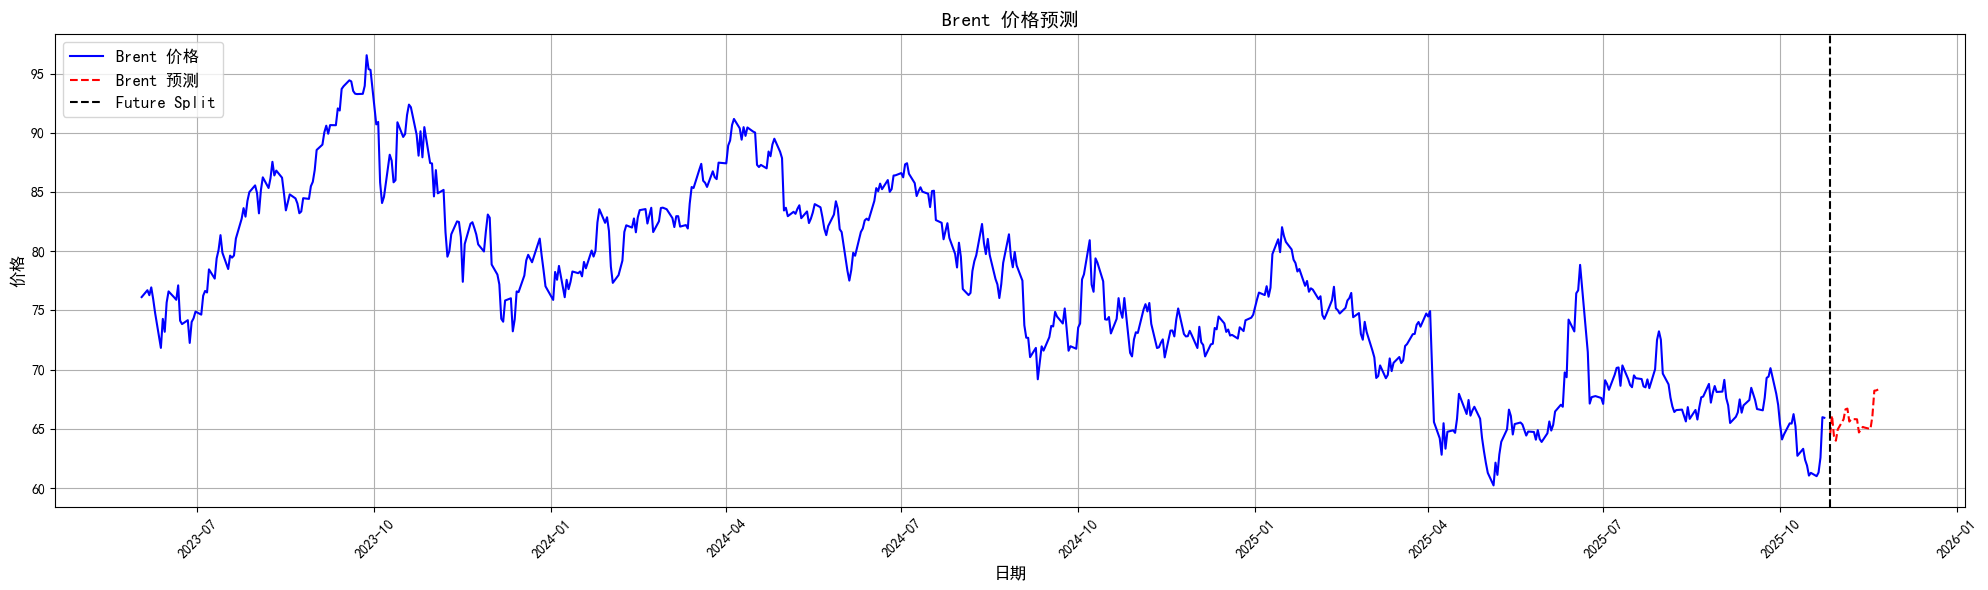

In [22]:
# 将日期转换回datetime格式
merged_price['Date'] = pd.to_datetime(merged_price['Date'])

# 创建图形
plt.figure(figsize=(20,6))

# 绘制布伦特原油现货价格
plt.plot(merged_price['Date'], 
         merged_price['布伦特原油期货价格'], 
         label='Brent 价格',
         color='blue')

# 绘制布伦特原油期货价格预测
plt.plot(merged_price['Date'],
         merged_price['Brent原油期货价格预测'],
         label='Brent 预测',
         color='red',
         linestyle='--')

plt.axvline(x=merged_df_brent['Date'].iloc[0], color='black', linestyle='--', label='Future Split')

plt.title('Brent 价格预测', fontsize=14)
plt.xlabel('日期', fontsize=12)
plt.ylabel('价格', fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)

# 旋转x轴标签
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


---

In [23]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.WTI_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "Brent-WTI价差"

# 调用函数更新数据
success = update_excel_data(merged_df, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [24]:
from Lcel import update_excel_data
file_path = "eta/1.WTI_数据上传.xlsx"
sheet_name = "详情页"
identifier = "Brent-WTI价差"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(monthly_df, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列
已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件


In [25]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.WTI_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "Brent原油期货价格"

# 调用函数更新数据
success = update_excel_data(merged_price, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [26]:
from Lcel import update_excel_data
file_path = "eta/1.WTI_数据上传.xlsx"
sheet_name = "详情页"
identifier = "Brent原油期货价格"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(monthly_merged, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列
已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件


In [27]:
count_prediction = merged_price.copy()
# 将实际值和预测值合并为一列
count_prediction['预测叠加'] = count_prediction['布伦特原油期货价格'].fillna(count_prediction['Brent原油期货价格预测'])
# 将日期列转换为datetime格式
count_prediction['Date'] = pd.to_datetime(count_prediction['Date'])
# 设置日期为索引
count_prediction.set_index('Date', inplace=True)
# 获取每月最后一天的数据
count_monthly_data = count_prediction.resample('ME').last()
# 重置索引并格式化日期
count_monthly_data = count_monthly_data.reset_index()
count_monthly_data['Date'] = count_monthly_data['Date'].dt.strftime('%Y/%m/%d')
# 显示结果
print(count_monthly_data[['Date', '预测叠加']].tail())


          Date       预测叠加
25  2025/07/31  72.530000
26  2025/08/31  68.120000
27  2025/09/30  67.020000
28  2025/10/31  64.963196
29  2025/11/30  68.330297
